In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import nibabel as nib
from tqdm import tqdm
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torch.utils.checkpoint as checkpoint
from sklearn.model_selection import train_test_split, StratifiedKFold
from collections import Counter
from torchsummary import summary
import warnings
from scipy.io import savemat

warnings.filterwarnings('ignore')

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cpu')
print ("device: [%s]"%(device))

device: [cuda:0]


In [3]:
base_dir = './data/'
con = ['adt', 'lh', 'rh', 'vis']

### sample dataset

In [78]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.data = torch.tensor(X, dtype = torch.float32)
        self.labels = torch.tensor(y, dtype = torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [79]:
sample_vols = sio.loadmat('./sensorimotor_4D_sample.mat')

X = np.concatenate((sample_vols['X_train'], sample_vols['X_test']), axis=0)
y = np.concatenate((sample_vols['y_train'], sample_vols['y_test']), axis=1)[0]

x_mean, x_std = np.mean(X), np.std(X)
X_centered = (X - x_mean)/x_std

X_train, X_test, y_train, y_test = train_test_split(X_centered, y, test_size=0.2, stratify=y, random_state=123)

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

print('train dataset: ', len(train_dataset))
print('test_dataset: ', len(test_dataset))

train dataset:  1152
test_dataset:  288


### beta dataset

In [36]:
class CustomDataset(Dataset):
    def __init__(self, data_paths, mapped_labels, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform


        mask_nii = nib.load(base_dir + 'allSub_mask.nii').get_fdata()

        for file_path, label in zip(tqdm(data_paths), mapped_labels):
            data_3d = nib.load(file_path).get_fdata()
            data_3d[np.isnan(data_3d)] = 0
            data_3d = data_3d * mask_nii
            data_3d = (data_3d - data_3d.mean())/data_3d.std()
            data_tensor = torch.tensor(data_3d, dtype=torch.float)
            self.data.append(data_tensor)
            self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [37]:
data_paths = []
labels = []
ex_labels = []
label_mapping = {'lh': 0, 'rh': 1, 'adt': 2, 'vis': 3}

for label_name, label_id in label_mapping.items():
    label_path = os.path.join(base_dir, label_name)
    if os.path.isdir(label_path):
        for sub_path in glob.glob(label_path + '/*/'):
            for nii_path in glob.glob(sub_path + 'GLM/beta_0*.nii')[:-1]:
                data_paths.append(nii_path)
                ex_labels.append(label_id)
                labels.append(label_id)
                
all_dataset = CustomDataset(data_paths, labels)
train_dataset, test_dataset = train_test_split(all_dataset, test_size = 0.2, stratify = ex_labels, random_state = 123)

print('all dataset: ', len(all_dataset))
print('train dataset: ', len(train_dataset))
print('test_dataset: ', len(test_dataset))

100%|██████████| 1800/1800 [00:38<00:00, 47.18it/s] 

all dataset:  1800
train dataset:  1440
test_dataset:  360


3


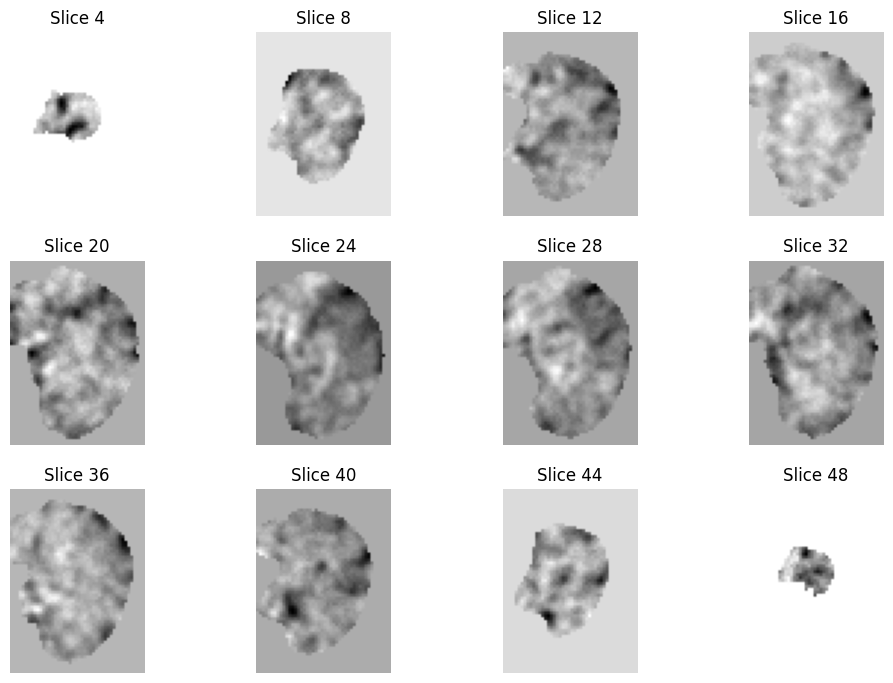

In [38]:
num_rows = 3
num_cols = 4
total_plots = num_rows * num_cols

print(train_dataset[0][1])
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 7))
fig.tight_layout()

for i, ax in enumerate(axes.flat):
    n = i 
    if n < train_dataset[0][0].shape[0]:
        ax.imshow(train_dataset[0][0][4+n*4], cmap='gray')
        ax.set_title(f"Slice {4+n*4}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.show()


### preprocessed dataset

In [123]:
class CustomDataset(Dataset):
    def __init__(self, data_paths, mapped_labels, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        slice_num = []
        for i in range(10):
            for j in [15, 35, 55]:
                slice_num.append(i + j)
        slice_num = sorted(slice_num)

        mask_nii = nib.load(base_dir + 'allSub_mask.nii').get_fdata()

        for file_path, label in zip(tqdm(data_paths), mapped_labels):
            nifti_data = nib.load(file_path).get_fdata()
            for i in slice_num:
                data_3d = nifti_data[:, :, :, i]
                data_3d = data_3d * mask_nii
                data_3d = (data_3d - data_3d.mean())/data_3d.std()
                data_tensor = torch.tensor(data_3d, dtype=torch.float)
                self.data.append(data_tensor)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [124]:
data_paths = []
labels = []
ex_labels = []
label_mapping = {'lh': 0, 'rh': 1, 'adt': 2, 'vis': 3}

for label_name, label_id in label_mapping.items():
    label_path = os.path.join(base_dir, label_name)
    if os.path.isdir(label_path):
        for nii_path in glob.glob(label_path + '/*/*.nii'):
            data_paths.append(nii_path)
            ex_labels.extend([label_id] * 30)
            labels.append(label_id)

all_dataset = CustomDataset(data_paths, labels)
train_dataset, test_dataset = train_test_split(all_dataset, test_size = 0.2, stratify = ex_labels, random_state = 123)

print('all dataset: ', len(all_dataset))
print('train dataset: ', len(train_dataset))
print('test_dataset: ', len(test_dataset))

all dataset:  1800
train dataset:  1440
test_dataset:  360


3


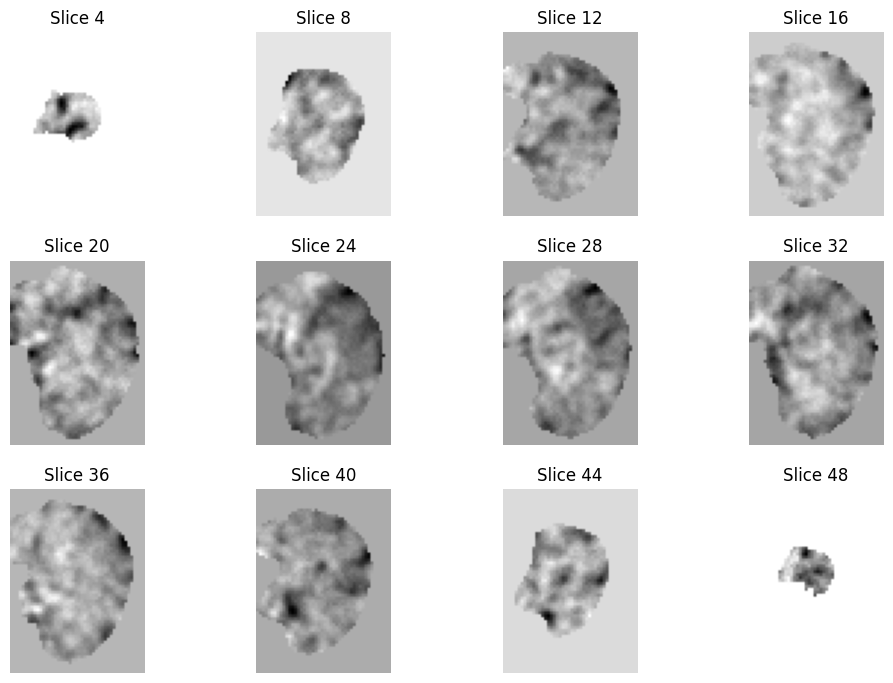

In [51]:
num_rows = 3
num_cols = 4
total_plots = num_rows * num_cols

print(train_dataset[0][1])
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 7))
fig.tight_layout()

for i, ax in enumerate(axes.flat):
    n = i 
    if n < train_dataset[0][0].shape[0]:
        ax.imshow(train_dataset[0][0][4+n*4], cmap='gray')
        ax.set_title(f"Slice {4+n*4}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.show()


### CNN model

In [39]:
class CNN3D(nn.Module):
    def __init__(self, input_channels=1, n_classes=4, dropout_rate=0.5, hid = 8):
        super(CNN3D, self).__init__()
        
        self.conv1 = nn.Conv3d(input_channels, hid, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=0)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm3d(hid)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        
        self.conv2 = nn.Conv3d(hid, hid*2, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=0)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm3d(hid * 2)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        
        self.conv3 = nn.Conv3d(hid*2, hid*4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=0)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm3d(hid * 4)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        
        self.fc1 = nn.Linear(1440, 128)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1)

        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

model = CNN3D().to(device)
summary(model, input_size=(1, 53, 63, 46))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 8, 47, 57, 40]           2,752
       BatchNorm3d-2        [-1, 8, 47, 57, 40]              16
              ReLU-3        [-1, 8, 47, 57, 40]               0
         MaxPool3d-4        [-1, 8, 23, 28, 20]               0
            Conv3d-5       [-1, 16, 19, 24, 16]          16,016
       BatchNorm3d-6       [-1, 16, 19, 24, 16]              32
              ReLU-7       [-1, 16, 19, 24, 16]               0
         MaxPool3d-8         [-1, 16, 9, 12, 8]               0
            Conv3d-9         [-1, 32, 7, 10, 6]          13,856
      BatchNorm3d-10         [-1, 32, 7, 10, 6]              64
             ReLU-11         [-1, 32, 7, 10, 6]               0
        MaxPool3d-12          [-1, 32, 3, 5, 3]               0
           Linear-13                  [-1, 128]         184,448
             ReLU-14                  [

In [40]:
class CNN3D(nn.Module):
    def __init__(self, input_channels=1, n_classes=4, dropout_rate=0.5, hid = 8):
        super(CNN3D, self).__init__()
        
        self.conv1 = nn.Conv3d(input_channels, hid, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=0)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm3d(input_channels)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        
        self.conv2 = nn.Conv3d(hid, hid*2, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=0)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm3d(hid * 2)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        
        self.conv3 = nn.Conv3d(hid*2, hid*4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=0)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm3d(hid * 4)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        
        self.fc1 = nn.Linear(1440, 128)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(self.bn1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1)

        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

model = CNN3D().to(device)
summary(model, input_size=(1, 53, 63, 46))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm3d-1        [-1, 1, 53, 63, 46]               2
            Conv3d-2        [-1, 8, 47, 57, 40]           2,752
              ReLU-3        [-1, 8, 47, 57, 40]               0
         MaxPool3d-4        [-1, 8, 23, 28, 20]               0
            Conv3d-5       [-1, 16, 19, 24, 16]          16,016
       BatchNorm3d-6       [-1, 16, 19, 24, 16]              32
              ReLU-7       [-1, 16, 19, 24, 16]               0
         MaxPool3d-8         [-1, 16, 9, 12, 8]               0
            Conv3d-9         [-1, 32, 7, 10, 6]          13,856
      BatchNorm3d-10         [-1, 32, 7, 10, 6]              64
             ReLU-11         [-1, 32, 7, 10, 6]               0
        MaxPool3d-12          [-1, 32, 3, 5, 3]               0
           Linear-13                  [-1, 128]         184,448
             ReLU-14                  [

In [41]:
def train(dataloader, model, loss_fn, optimizer, l1 = False, l1_weight = 1):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.unsqueeze(1).to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()

        if l1:
            l1_parameters = []
            for parameter in model.parameters():
                l1_parameters.append(parameter.view(-1))
            l1 = l1_weight * model.compute_l1(torch.cat(l1_parameters))
            loss += l1

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(pred, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    avg_train_loss = train_loss / len(dataloader)
    train_accuracy = correct / total

    return avg_train_loss, train_accuracy


In [42]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.unsqueeze(1).to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            _, predicted = torch.max(pred, 1)
            correct += (predicted == y).sum().item()

    avg_test_loss = test_loss / num_batches
    test_accuracy = correct / size

    # print(f"Test Error: \n Accuracy: {(100 * test_accuracy):>0.1f}%, Avg loss: {avg_test_loss:>8f} \n")

    return avg_test_loss, test_accuracy


In [43]:
def plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Fold 1/5
-------------------------------


100%|██████████| 1000/1000 [48:09<00:00,  2.89s/it]


Train Loss: 0.3414, Train Accuracy: 87.00%
Test Loss: 1.2542, Test Accuracy: 60.83%

Fold 2/5
-------------------------------


100%|██████████| 1000/1000 [32:40<00:00,  1.96s/it]


Train Loss: 0.3925, Train Accuracy: 84.37%
Test Loss: 1.1649, Test Accuracy: 61.19%

Fold 3/5
-------------------------------


100%|██████████| 1000/1000 [30:30<00:00,  1.83s/it]


Train Loss: 0.2732, Train Accuracy: 89.44%
Test Loss: 1.0972, Test Accuracy: 65.48%

Fold 4/5
-------------------------------


100%|██████████| 1000/1000 [29:58<00:00,  1.80s/it]


Train Loss: 0.2864, Train Accuracy: 88.86%
Test Loss: 1.1973, Test Accuracy: 64.65%

Fold 5/5
-------------------------------


100%|██████████| 1000/1000 [30:42<00:00,  1.84s/it]

Train Loss: 0.3262, Train Accuracy: 87.27%
Test Loss: 1.2321, Test Accuracy: 61.22%

K-Fold Cross Validation Summary:
Average Train Loss: 0.3239
Average Train Accuracy: 87.39%
Average Test Loss: 1.1891
Average Test Accuracy: 62.67%


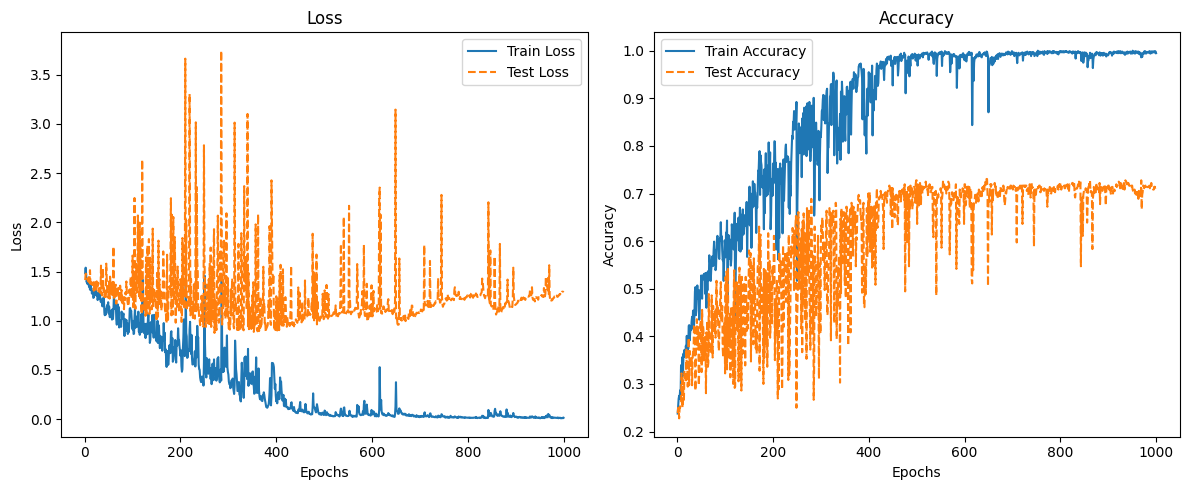

In [50]:
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=123)

fold_train_losses, fold_train_accuracies = [], []
fold_test_losses, fold_test_accuracies = [], []

epochs = 1000; batch_size = 50

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_data = [train_dataset[i][0] for i in range(len(train_dataset))]
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]

for fold, (train_idx, test_idx) in enumerate(skf.split(train_data, train_labels)):
    print(f"Fold {fold+1}/{k_folds}")
    print("-------------------------------")

    train_fold_dataset = Subset(train_dataset, train_idx)
    train_loader = DataLoader(train_fold_dataset, batch_size=int(len(train_fold_dataset)/k_folds), shuffle = True)

    # inp_size = input_size(train_loader)

    # model = CNN3D(inp=(1, 53, 63, 46)).to(device)
    model = CNN3D().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    train_losses_all, train_accuracies_all = [], []
    test_losses_all, test_accuracies_all = [], []

    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train(train_loader, model, loss_fn, optimizer)
        train_losses_all.append(train_loss)
        train_accuracies_all.append(train_accuracy)

        test_loss, test_accuracy = test(test_loader, model, loss_fn)
        test_losses_all.append(test_loss)
        test_accuracies_all.append(test_accuracy)

    fold_train_losses.append(sum(train_losses_all) / len(train_losses_all))
    fold_train_accuracies.append(sum(train_accuracies_all) / len(train_accuracies_all))
    fold_test_losses.append(sum(test_losses_all) / len(test_losses_all))
    fold_test_accuracies.append(sum(test_accuracies_all) / len(test_accuracies_all))

    # print(f"Fold {fold+1} Summary: ")
    print(f"Train Loss: {fold_train_losses[-1]:.4f}, Train Accuracy: {fold_train_accuracies[-1]*100:.2f}%")
    print(f"Test Loss: {fold_test_losses[-1]:.4f}, Test Accuracy: {fold_test_accuracies[-1]*100:.2f}%")
    print()

print("K-Fold Cross Validation Summary:")
print(f"Average Train Loss: {sum(fold_train_losses) / k_folds:.4f}")
print(f"Average Train Accuracy: {sum(fold_train_accuracies) / k_folds * 100:.2f}%")
print(f"Average Test Loss: {sum(fold_test_losses) / k_folds:.4f}")
print(f"Average Test Accuracy: {sum(fold_test_accuracies) / k_folds * 100:.2f}%")

plot_metrics(train_losses_all, train_accuracies_all, test_losses_all, test_accuracies_all)

1


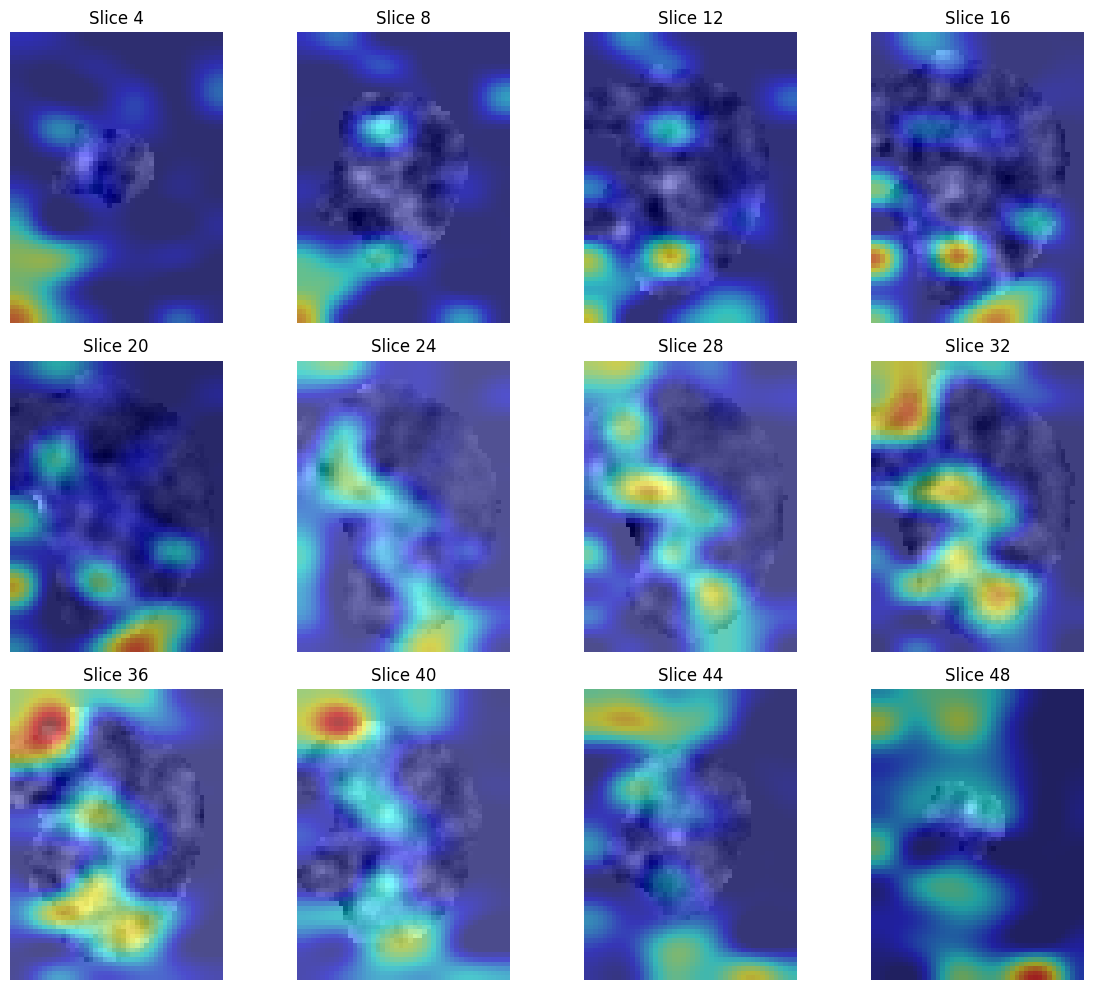

In [49]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

cam = GradCAM(model=model, target_layers=[model.conv3])
cam.batch_size = 1

# label_mapping = {'lh': 0, 'rh': 1, 'adt': 2, 'vis': 3}
tmp = 0
input_tensor = test_dataset[tmp][0].unsqueeze(0).unsqueeze(0).to(device)
target_class = int(test_dataset[tmp][1])
print(target_class)

grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(target_class)])
grayscale_cam = grayscale_cam[0, :]

fig, axes = plt.subplots(3, 4, figsize=(12, 10))

for i, ax in enumerate(axes.flat):
    n = i
    if n < grayscale_cam.shape[0]:
        original_image = test_dataset[tmp][0][4+n*4].cpu().numpy()
        grayscale_cam_slice = grayscale_cam[4+n*4]

        original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())
        original_image_rgb = np.stack([original_image] * 3, axis=-1)

        cam_on_image = show_cam_on_image(original_image_rgb, grayscale_cam_slice, use_rgb=True)

        ax.imshow(cam_on_image)
        ax.set_title(f"Slice {4+n*4}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()
